In [31]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
import pandas as pd

%matplotlib inline

In [32]:
df = pd.read_csv('annual-co2-emissions-per-country.csv')
df.head()

,Entity,Code,Year,Date,Annual CO₂ emissions
0,United States,USA,1901,1/1/1901,721527550
1,United States,USA,1902,1/1/1902,764495740
2,United States,USA,1903,1/1/1903,894406900
3,United States,USA,1904,1/1/1904,882057540
4,United States,USA,1905,1/1/1905,986482400


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Entity                121 non-null    object
 1   Code                  121 non-null    object
 2   Year                  121 non-null    int64 
 3   Date                  121 non-null    object
 4   Annual CO₂ emissions  121 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 4.9+ KB


In [34]:
df = df[['Date','Annual CO₂ emissions']]
df.head()

,Date,Annual CO₂ emissions
0,1/1/1901,721527550
1,1/1/1902,764495740
2,1/1/1903,894406900
3,1/1/1904,882057540
4,1/1/1905,986482400


In [35]:
df['Date']=pd.to_datetime(df['Date'])

In [36]:
df = df.set_index('Date')
df.head()

,Annual CO₂ emissions
Date,
1901-01-01,721527550
1902-01-01,764495740
1903-01-01,894406900
1904-01-01,882057540
1905-01-01,986482400


<Axes: xlabel='Date'>

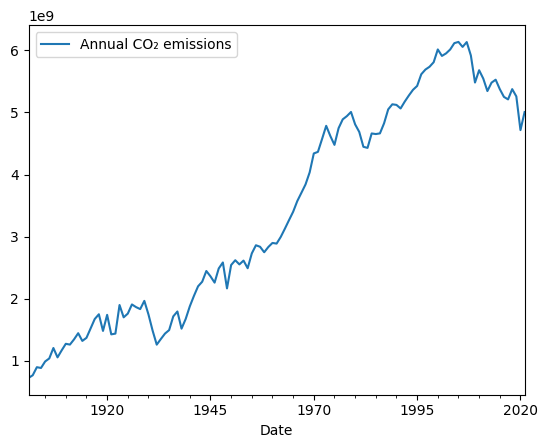

In [37]:
df.plot()

* Above graph shows CO2 emissions by USA since 1900
* We will use Ad-Fuller test to check stationarity of the data

In [38]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [39]:
adf_test(df['Annual CO₂ emissions'])

ADF Statistics: -1.2466469105401388
p- value: 0.6532146274850386
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


* Since the data is non-stationary, we will use First differencing to convert it into stationary

In [40]:
df['First difference']=df['Annual CO₂ emissions']-df['Annual CO₂ emissions'].shift(1)

In [41]:
df.head(10)

,Annual CO₂ emissions,First difference
Date,,
1901-01-01,721527550,NaN
1902-01-01,764495740,42968190.0
1903-01-01,894406900,129911160.0
1904-01-01,882057540,-12349360.0
1905-01-01,986482400,104424860.0
1906-01-01,1035471170,48988770.0
1907-01-01,1203861500,168390330.0
1908-01-01,1052812860,-151048640.0
1909-01-01,1165706200,112893340.0


In [42]:
## Ad-Fuller test on 'First Difference'

adf_test(df['First difference'].dropna())

ADF Statistics: -5.003200971856679
p- value: 2.187169043743936e-05
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Date'>

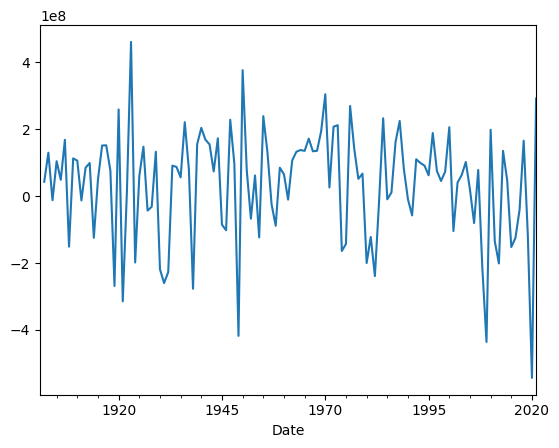

In [43]:
df['First difference'].plot()

* Data looks stationary
* Now we will plot ACF / PACF plot to check AR and MA componenent of the ARIMA model

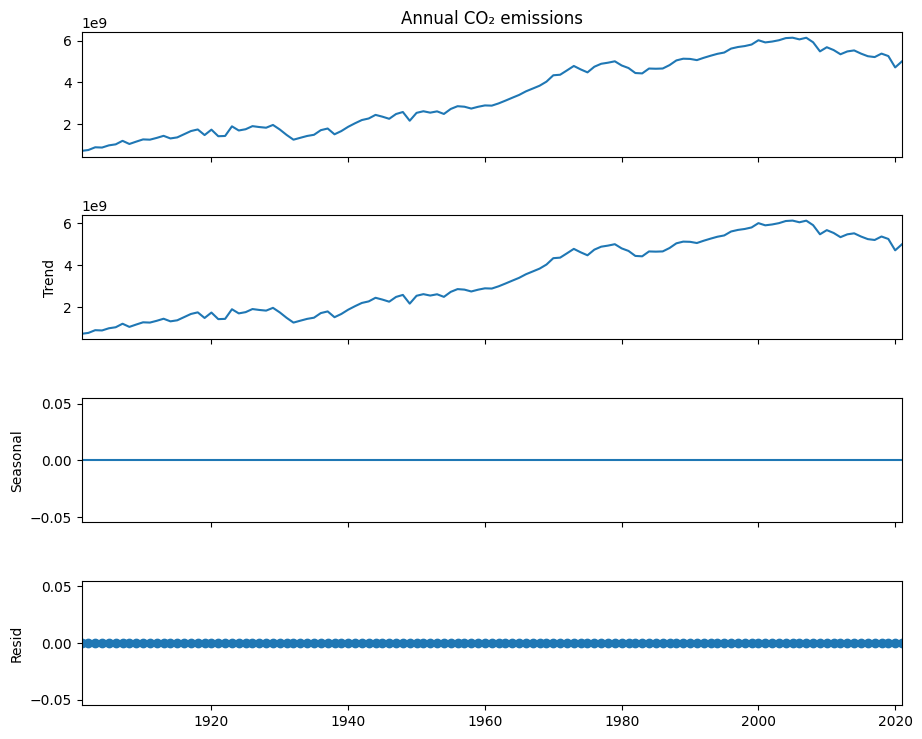

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

# seasonal_decompose for additive model
seasonal_decompose(df['Annual CO₂ emissions'], model = 'additive').plot().set_size_inches(10, 8)

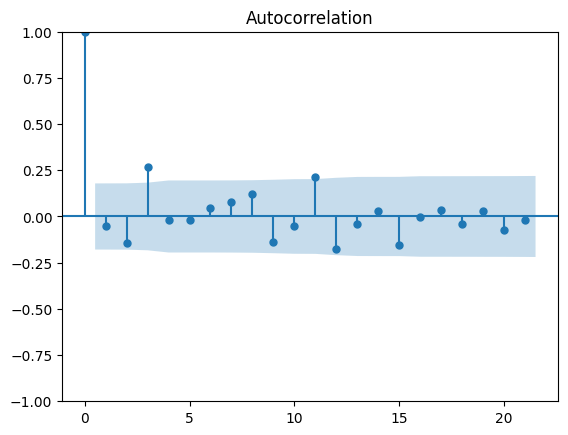

In [45]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
acf = plot_acf(df["First difference"].dropna())

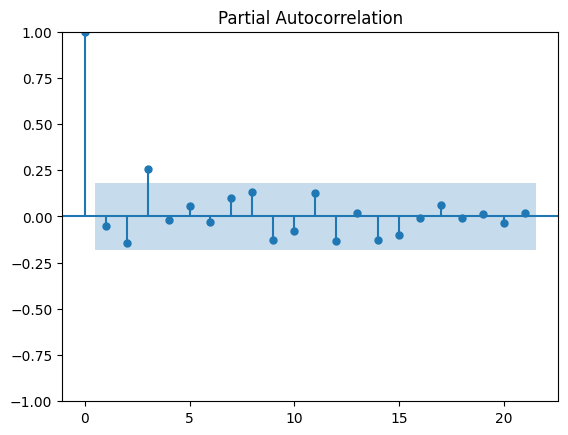

In [46]:
pacf12 = plot_pacf(df["First difference"].dropna())

In [47]:
## train test split

from datetime import datetime,timedelta
train_dataset_end=datetime(2011,1,1)
test_dataset_end=datetime(2021,1,1)

train_data=df[:train_dataset_end]
test_data=df[train_dataset_end+timedelta(days=1):test_dataset_end]

In [60]:
from statsmodels.tsa.arima.model import ARIMA
model_ARIMA=ARIMA(train_data['Annual CO₂ emissions'],order=(3,1,11))

C:\Users\srija\Documents\DataScience_Salary_Predictor\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\srija\Documents\DataScience_Salary_Predictor\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\srija\Documents\DataScience_Salary_Predictor\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [61]:
model_Arima_fit=model_ARIMA.fit()

C:\Users\srija\Documents\DataScience_Salary_Predictor\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\srija\Documents\DataScience_Salary_Predictor\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\srija\Documents\DataScience_Salary_Predictor\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [62]:
model_Arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Annual CO₂ emissions   No. Observations:                  111
Model:                  ARIMA(3, 1, 11)   Log Likelihood               -2225.781
Date:                  Mon, 30 Oct 2023   AIC                           4481.561
Time:                          15:53:39   BIC                           4522.068
Sample:                      01-01-1901   HQIC                          4497.991
                           - 01-01-2011                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1330      0.186     -0.713      0.476      -0.498       0.232
ar.L2          0.1361      0.199      0.684      0.494      -0.254       0.526
ar.L3          0.8437      0.189      4.472      0.000       0.474       1.213
ma.L1          0.1870      0.224      0.836      0.403      -0.251       0.625
ma.L2         -0.1123      0.227     -0.495      0.621      -0.557       0.332
ma.L3         -0.6562      0.315     -2.082      0.037      -1.274      -0.038
ma.L4         -0.0216      0.142     -0.152      0.879      -0.300       0.257
ma.L5         -0.0160      0.140     -0.115      0.909      -0.289       0.257
ma.L6         -0.0465      0.131     -0.354      0.723      -0.304       0.211
ma.L7          0.2092      0.123      1.704      0.088      -0.031       0.450
ma.L8          0.0940      0.154      0.611      0.541      -0.207       0.395
ma.L9         -0.2157      0.155     -1.392      0.164      -0.520       0.088
ma.L10        -0.1349      0.158     -0.856      0.392      -0.444       0.174
ma.L11         0.0556      0.122      0.457      0.648      -0.183       0.294
sigma2      2.123e+16   1.62e-17   1.31e+33      0.000    2.12e+16    2.12e+16
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 8.00
Prob(Q):                              0.86   Prob(JB):                         0.02
Heteroskedasticity (H):               0.82   Skew:                            -0.66
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.38e+49. Standard errors may be unstable.
"""

In [63]:
##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

2012-01-01 00:00:00
2021-01-01 00:00:00


In [64]:
pred=model_Arima_fit.predict(start=pred_start_date,end=pred_end_date)
residuals=test_data['Annual CO₂ emissions']-pred

In [65]:
residuals

Date
2012-01-01   -8.434409e+07
2013-01-01   -3.347548e+07
2014-01-01    9.004103e+07
2015-01-01    2.378986e+07
2016-01-01   -8.676459e+07
2017-01-01   -9.169303e+07
2018-01-01    4.751013e+07
2019-01-01   -5.211220e+07
2020-01-01   -5.564196e+08
2021-01-01   -3.105781e+08
dtype: float64

In [66]:
pred

2012-01-01    5.429798e+09
2013-01-01    5.514401e+09
2014-01-01    5.438830e+09
2015-01-01    5.352788e+09
2016-01-01    5.338522e+09
2017-01-01    5.302650e+09
2018-01-01    5.329147e+09
2019-01-01    5.311256e+09
2020-01-01    5.272111e+09
2021-01-01    5.317914e+09
Freq: AS-JAN, Name: predicted_mean, dtype: float64

<Axes: ylabel='Density'>

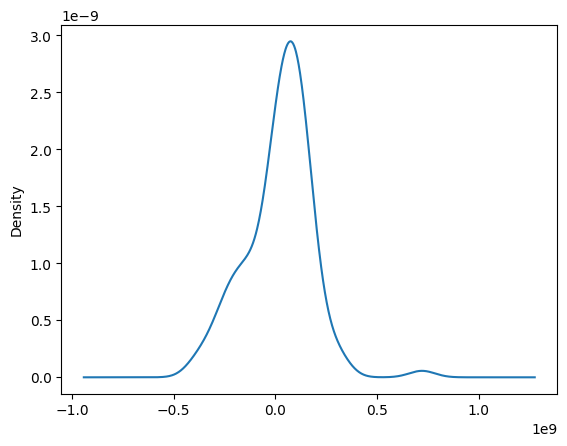

In [67]:
model_Arima_fit.resid.plot(kind='kde')

In [68]:
test_data['Predicted_ARIMA']=pred

C:\Users\srija\AppData\Local\Temp\ipykernel_18560\95659616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_ARIMA']=pred


In [69]:
test_data

,Annual CO₂ emissions,First difference,Predicted_ARIMA
Date,,,
2012-01-01,5345454000,-201175000.0,5.429798e+09
2013-01-01,5480926000,135472000.0,5.514401e+09
2014-01-01,5528871000,47945000.0,5.438830e+09
2015-01-01,5376578000,-152293000.0,5.352788e+09
2016-01-01,5251757600,-124820400.0,5.338522e+09
2017-01-01,5210957300,-40800300.0,5.302650e+09
2018-01-01,5376657400,165700100.0,5.329147e+09
2019-01-01,5259144000,-117513400.0,5.311256e+09
2020-01-01,4715691000,-543453000.0,5.272111e+09


<Axes: xlabel='Date'>

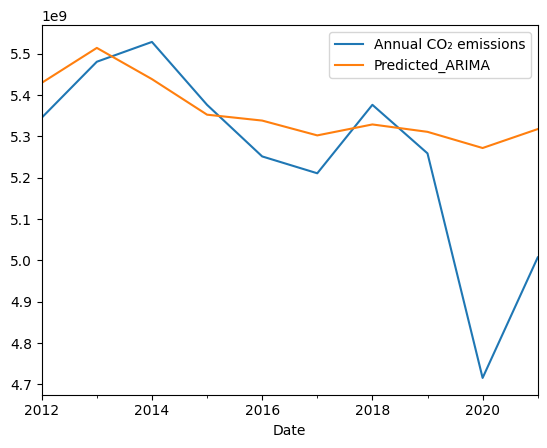

In [70]:
test_data[['Annual CO₂ emissions','Predicted_ARIMA']].plot()

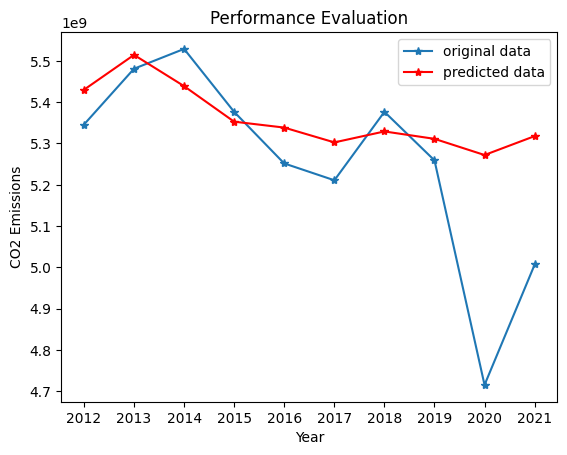

In [71]:
plt.plot(test_data['Annual CO₂ emissions'], label = 'original data', marker = '*')
plt.plot(test_data['Predicted_ARIMA'], color='red', label = 'predicted data', marker = '*')
plt.title('Performance Evaluation')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.show()